Here we are trying to find out more about what exactly is the __unknown__ in this problem ?

* We have to accurately predict the severity of the claims. 
* __Severity__ is generally defined as the amount of damage that is inflicted by a loss or catastrophe.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import os,sys

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

basepath = os.path.expanduser('~/Desktop/src/AllState_Claims_Severity/')
sys.path.append(os.path.join(basepath, 'src'))

np.random.seed(2016)

from data import *

In [2]:
# common script to load datasets
train, test, sample_sub = load_data()

** Shape of the traininig dataset. **

In [7]:
print('Shape of the training dataset ', train.shape)

Shape of the training dataset  (188318, 132)


** There are around 2 lakh instances available and 131 features and a target variable that were recorded in the training set. **

** Shape of the test dataset. **

In [8]:
print('Shape of the test dataset ', test.shape)

Shape of the test dataset  (125546, 131)


** There are around 1.2 lakh instances on which we have to generate our predictions. **

** Loss variable defines the amount of damage inflicted. **

In [11]:
train.loss.describe()

count    188318.000000
mean       3037.337686
std        2904.086186
min           0.670000
25%        1204.460000
50%        2115.570000
75%        3864.045000
max      121012.250000
Name: loss, dtype: float64

** Loss Summary **

* Loss can be as low as 0.67 and could go as high as  121012.25, so our model has to be able to predict across this range of values.
* Around 70% of the values are less than mean which means that in very few cases did we suffer huge amount of losses.

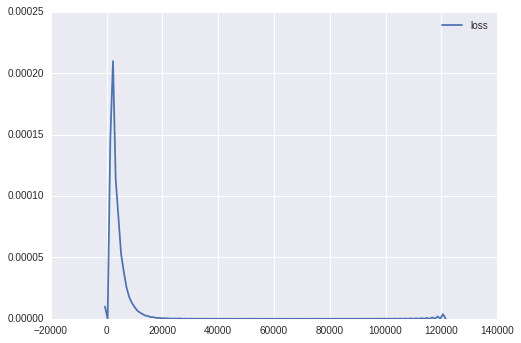

In [13]:
sns.kdeplot(train.loss);

** This is verified by this plot. **

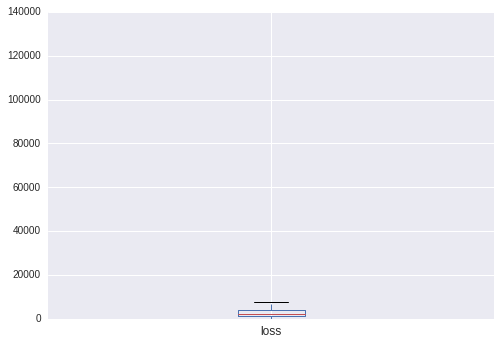

In [15]:
train.boxplot(column='loss');

** After taking the log transformation of the unknown variable. **

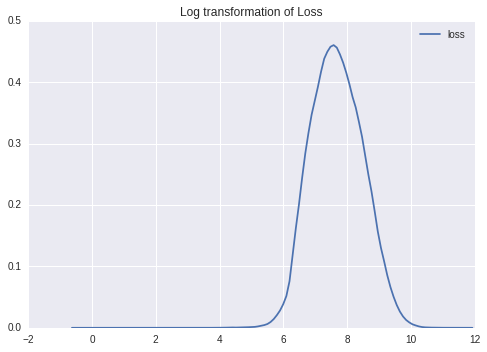

In [30]:
sns.kdeplot(train.loss.map(np.log))
plt.title('Log transformation of Loss');

** Looks better and easy to work with. **

** Lets convert into categorical form by taking the floor and see if we can bin this variable. **

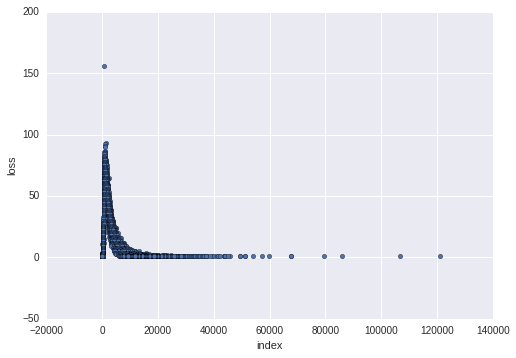

In [24]:
train.loss.map(np.floor).value_counts().reset_index().plot.scatter(x='index', y='loss');

** There are very few instances of the high loss values, so it would not be very easy to model these details. **

In [25]:
train.loss.map(np.floor).value_counts().sort_values(ascending=False)

580.0      156
1212.0      93
970.0       92
942.0       91
1119.0      90
1007.0      87
798.0       86
1074.0      86
914.0       85
912.0       85
1200.0      85
1005.0      85
943.0       84
840.0       84
660.0       83
1001.0      83
903.0       83
1080.0      83
803.0       82
973.0       81
851.0       81
1006.0      81
891.0       81
872.0       81
909.0       81
866.0       80
846.0       80
793.0       80
815.0       80
1442.0      79
          ... 
45982.0      1
39502.0      1
40017.0      1
27120.0      1
27075.0      1
27047.0      1
30194.0      1
29601.0      1
29604.0      1
29622.0      1
29726.0      1
29733.0      1
29814.0      1
28518.0      1
29826.0      1
30054.0      1
30077.0      1
30318.0      1
26964.0      1
30376.0      1
30377.0      1
30435.0      1
30444.0      1
30499.0      1
28532.0      1
28420.0      1
30775.0      1
27487.0      1
26873.0      1
0.0          1
Name: loss, dtype: int64

** There is something special with loss value of 580, as it has highest frequency of occurence in the training set. **

** Number of unique loss values in the training set. **

In [27]:
print('Number of unique loss values in the training set ', train.loss.nunique())

Number of unique loss values in the training set  158223


** Is there an obvious pattern in the loss over time. **

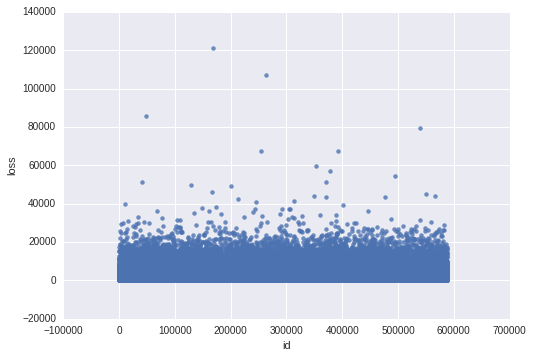

In [33]:
sns.regplot(x='id', y='loss', data=train, fit_reg=False);

** Looks random as hell. **

** Can we create some meaningful buckets based on the frequency of the loss values. **

In [51]:
loss = train.loss

# create variable based on the frequency of the target variable
loss_freq = train.groupby(['loss'])['loss'].transform(lambda x: len(x))

# Bin the variable with 10 bins
bins   = np.linspace(loss_freq.min(), loss_freq.max(), 3)
labels = np.digitize(loss_freq, bins)

In [56]:
loss.reset_index().groupby(['loss']).size()

loss
0.67         1
5.25         1
6.00         1
8.40         1
10.00        1
11.00        1
20.11        1
20.99        1
21.00        1
23.69        1
28.46        1
34.26        1
36.00        1
36.45        1
38.40        1
47.28        1
54.34        1
57.29        1
59.95        1
60.80        1
61.48        1
61.69        1
63.10        1
63.15        1
63.38        1
63.90        1
65.97        1
67.32        1
70.29        1
71.84        1
            ..
37167.06     1
37313.28     1
37379.61     1
37392.08     1
37724.85     1
38504.79     1
39502.24     1
40017.17     1
41148.69     1
41596.91     1
42290.84     1
43704.48     1
43707.25     1
44001.42     1
44035.07     1
45269.29     1
45982.60     1
49249.07     1
49549.85     1
51127.50     1
51383.04     1
54190.39     1
57224.55     1
59826.79     1
67537.73     1
67667.16     1
79623.52     1
85923.56     1
106863.00    1
121012.25    1
dtype: int64

In [52]:
# frequency count of various labels
pd.Series(labels).value_counts()

1    188214
3       104
dtype: int64

** As we can see that there are some values which are pretty unusual and have to handled differently. ** 

In [35]:
df = pd.DataFrame({"a": np.random.random(100),
                       "b": np.random.random(100),
                       "id": np.arange(100)})

In [36]:
df.head(2)

,a,b,id
0,0.896705,0.076906,0
1,0.730239,0.465551,1


In [37]:
# Bin the data frame by "a" with 10 bins...
bins = np.linspace(df.a.min(), df.a.max(), 10)

In [39]:
groups = df.groupby(np.digitize(df.a, bins))

array([ 9,  7,  8,  7,  5,  6,  2,  7,  7,  6,  6,  3,  2,  2,  6,  6,  1,
        9,  4,  5,  5,  1,  2,  2,  4,  4,  3,  4,  8,  4,  2,  9,  7,  7,
        4,  6,  5,  1,  7,  4,  3,  6,  2,  4,  4,  9,  4,  7,  3,  1,  3,
        1,  7,  2,  4,  1,  8,  8,  7,  1,  5,  1,  6,  6,  6,  2,  3,  9,
        8,  2,  6,  8,  2,  7,  3,  2,  8,  3,  3,  5,  2, 10,  7,  2,  1,
        5,  2,  7,  3,  3,  6,  5,  2,  2,  1,  3,  9,  3,  3,  2])